In [3]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import cv2

from superpoint.settings import DATA_PATH, EXPER_PATH
from superpoint.models.utils import detector_head, homography_adaptation, box_nms
from superpoint.models.backbones.vgg import vgg_backbone
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2
tf.logging.set_verbosity(0)

In [43]:
image_name = 'COCO_train2014_000000000071.jpg' #'COCO_train2014_000000151493.jpg' #'COCO_train2014_000000114404.jpg'
model_name = 'magic-point_synth_120-160'

In [44]:
base_path = Path(DATA_PATH, 'COCO/train2014/')
filename = Path(base_path, image_name)
checkpoint = Path(EXPER_PATH, model_name) 

In [45]:
net_config = {
    'data_format': 'channels_last',
    'grid_size': 8,
    'detection_threshold': 0.9,
    'nms': 8,
    'homography_adaptation': {'num': 100, 'aggregation': 'max'},
    'training': False
}
def net(image):
    with tf.variable_scope('magicpoint', reuse=tf.AUTO_REUSE):
        image = tf.expand_dims(image, axis=0)
        features = vgg_backbone(image, **net_config)
        outputs = detector_head(features, **net_config)
        return {k: v[0] for k, v in outputs.items()}

In [46]:
tf.reset_default_graph(), 
image = tf.image.decode_jpeg(tf.read_file(str(filename)), channels=1)
image = tf.to_float(tf.image.resize_images(image, [240, 320]))
outputs = homography_adaptation(image, net, net_config)
outputs['prob_nms'] = box_nms(outputs['prob'], net_config['nms'])
outputs['pred'] = tf.to_int32(tf.greater_equal(outputs['prob_nms'], net_config['detection_threshold']))

In [47]:
def draw_keypoints(img, corners, color, s = 4):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

200 detections


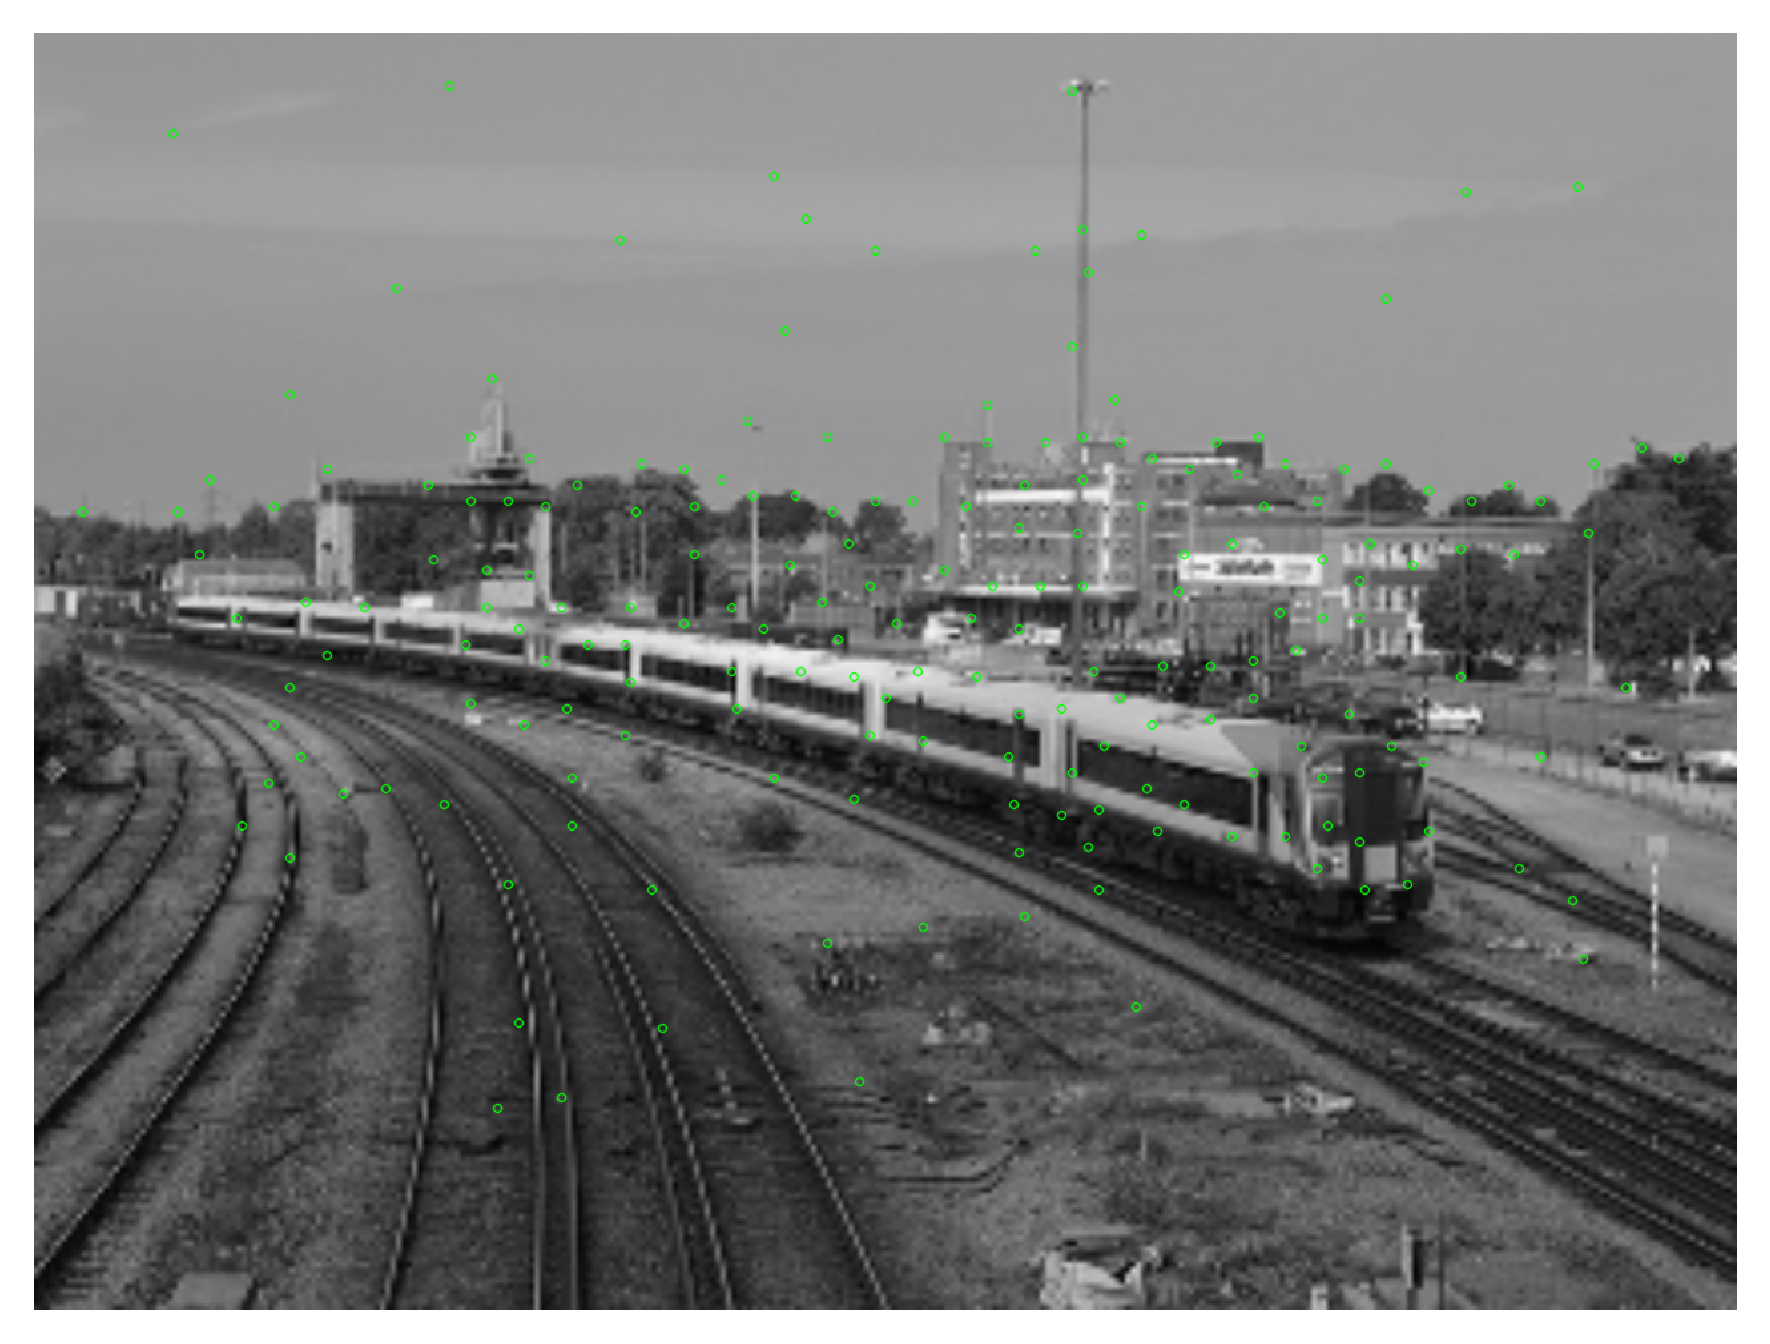

In [48]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint(checkpoint));
    im, _out = sess.run([image, outputs])
    plot_imgs([draw_keypoints(im[..., 0], np.where(_out['pred']), (0, 255, 0))/255.], dpi=300)
    print('{} detections'.format(np.sum(_out['pred'])))

376 detections


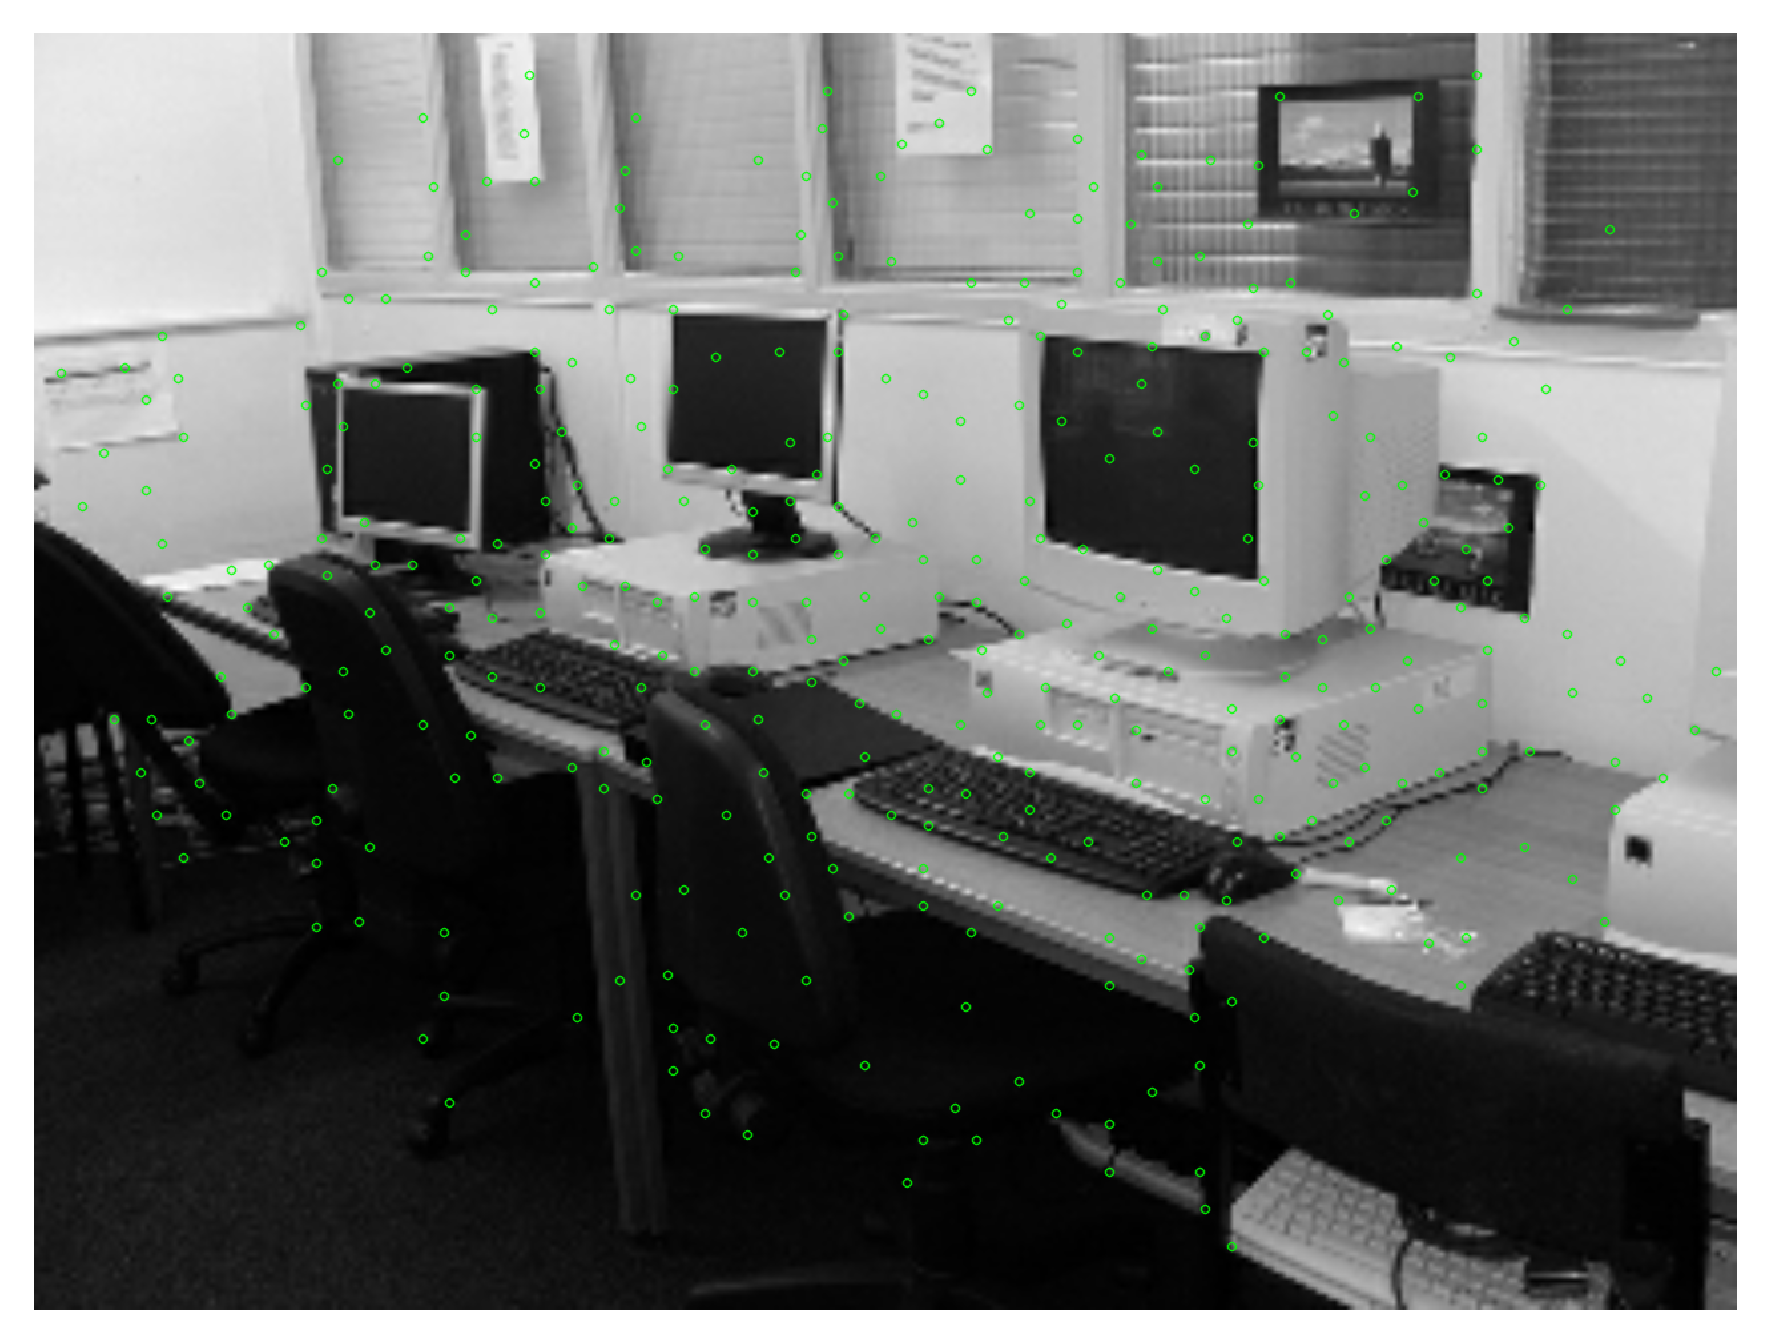

470 detections


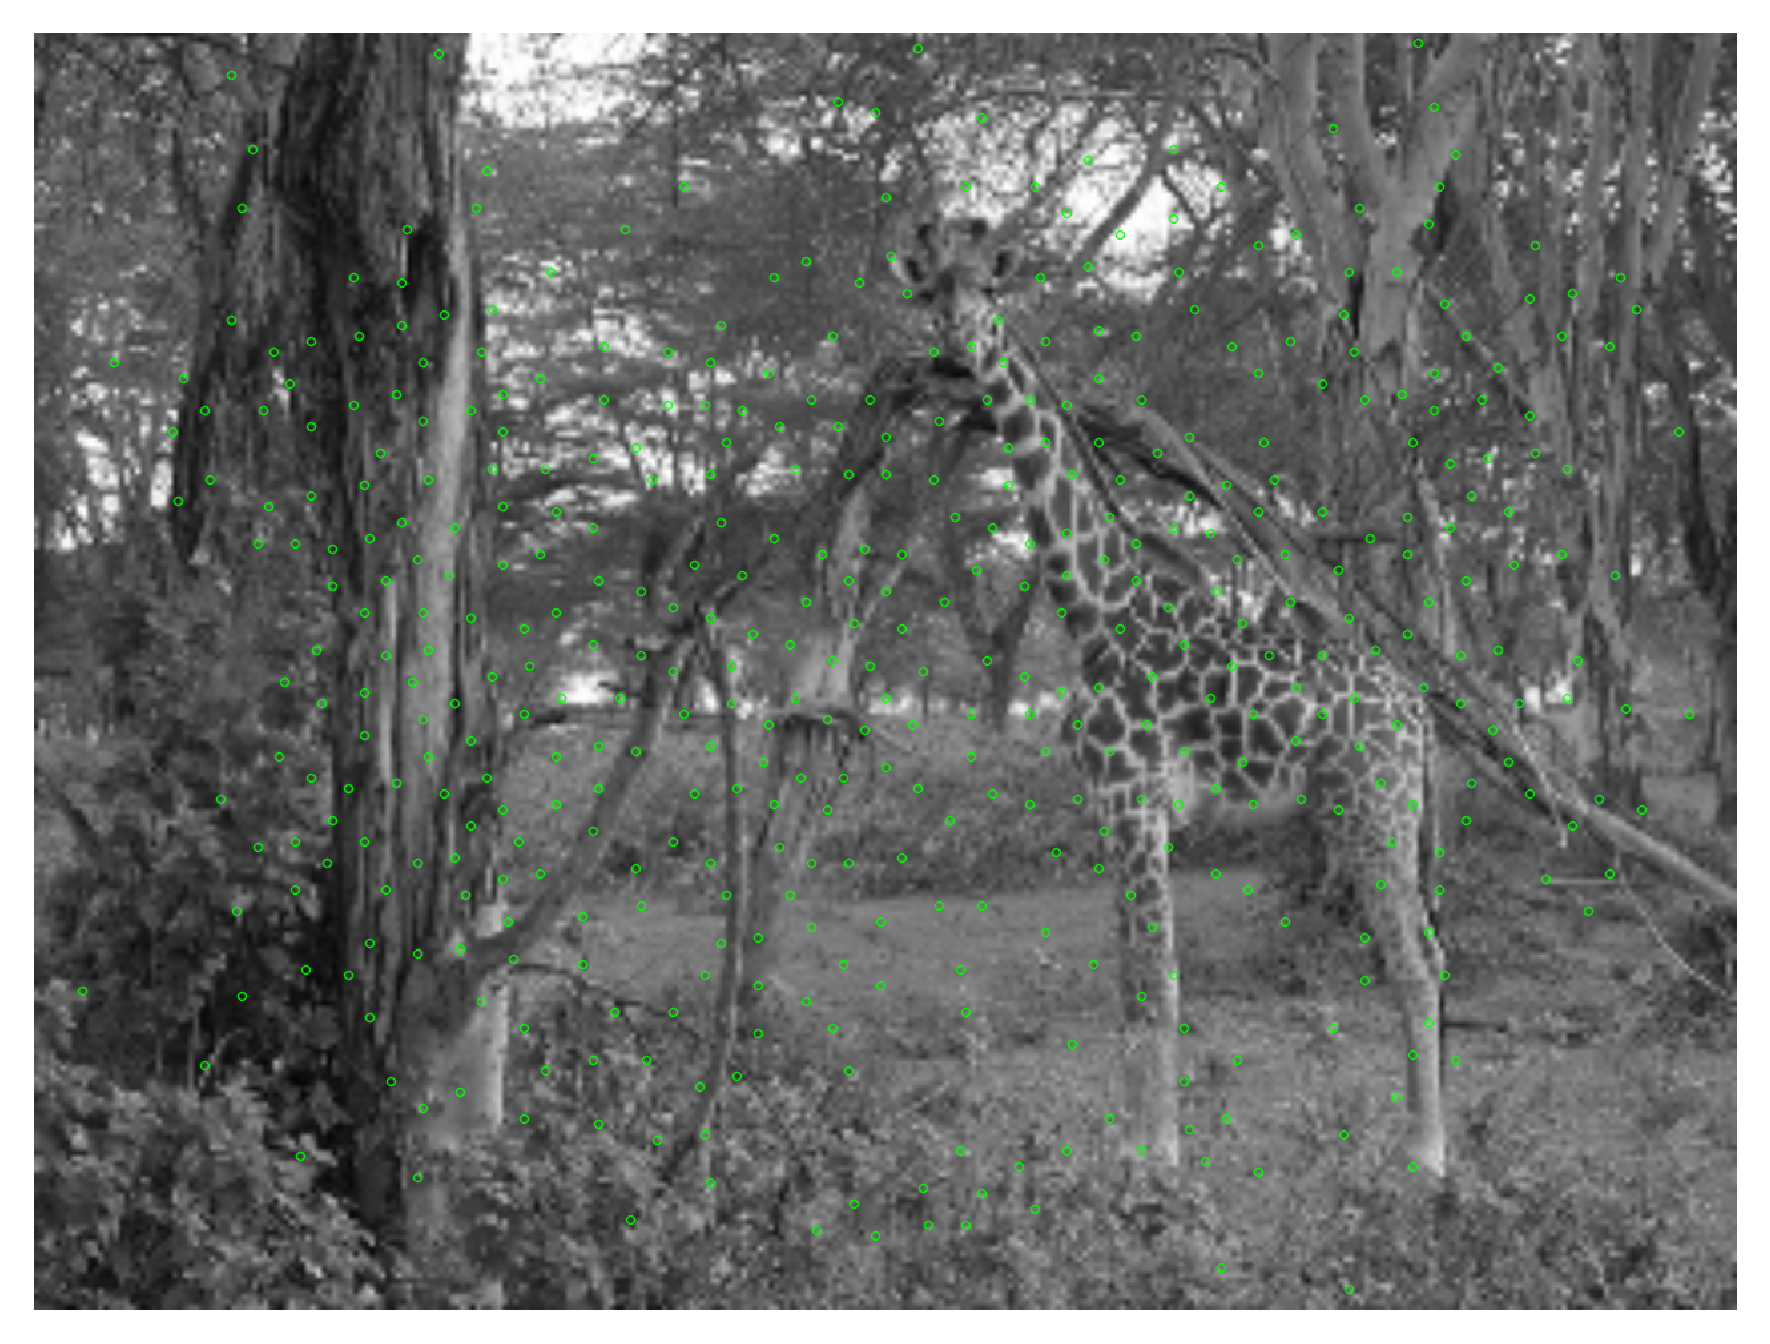

## Mean proability: only few detections even without NMS

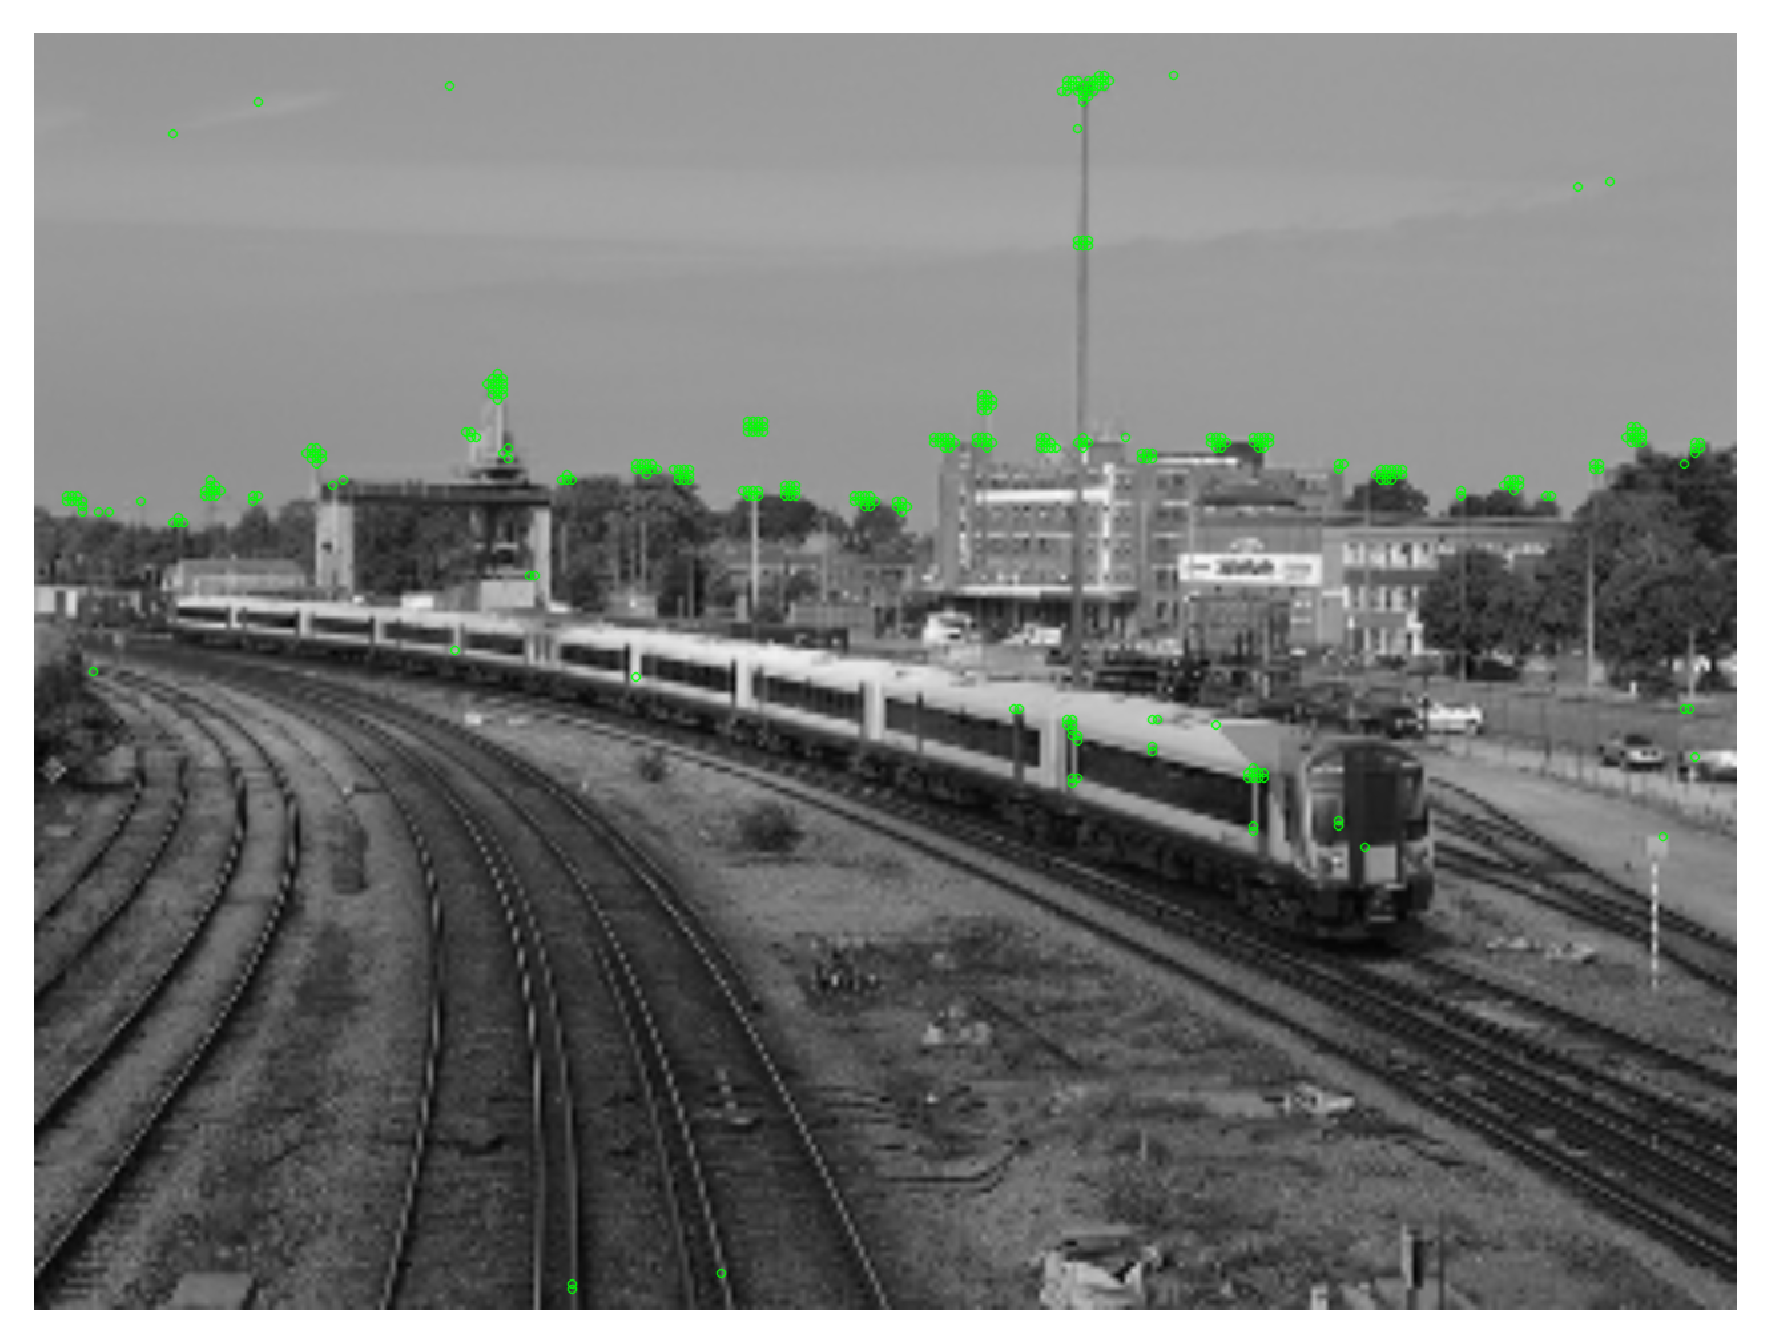

In [183]:
plot_imgs([draw_keypoints(im[..., 0], np.where(_out['mean_prob']>0.05), (0, 255, 0))/255.], dpi=300)

## Without homography adaptation: the detections are not evenly distributed

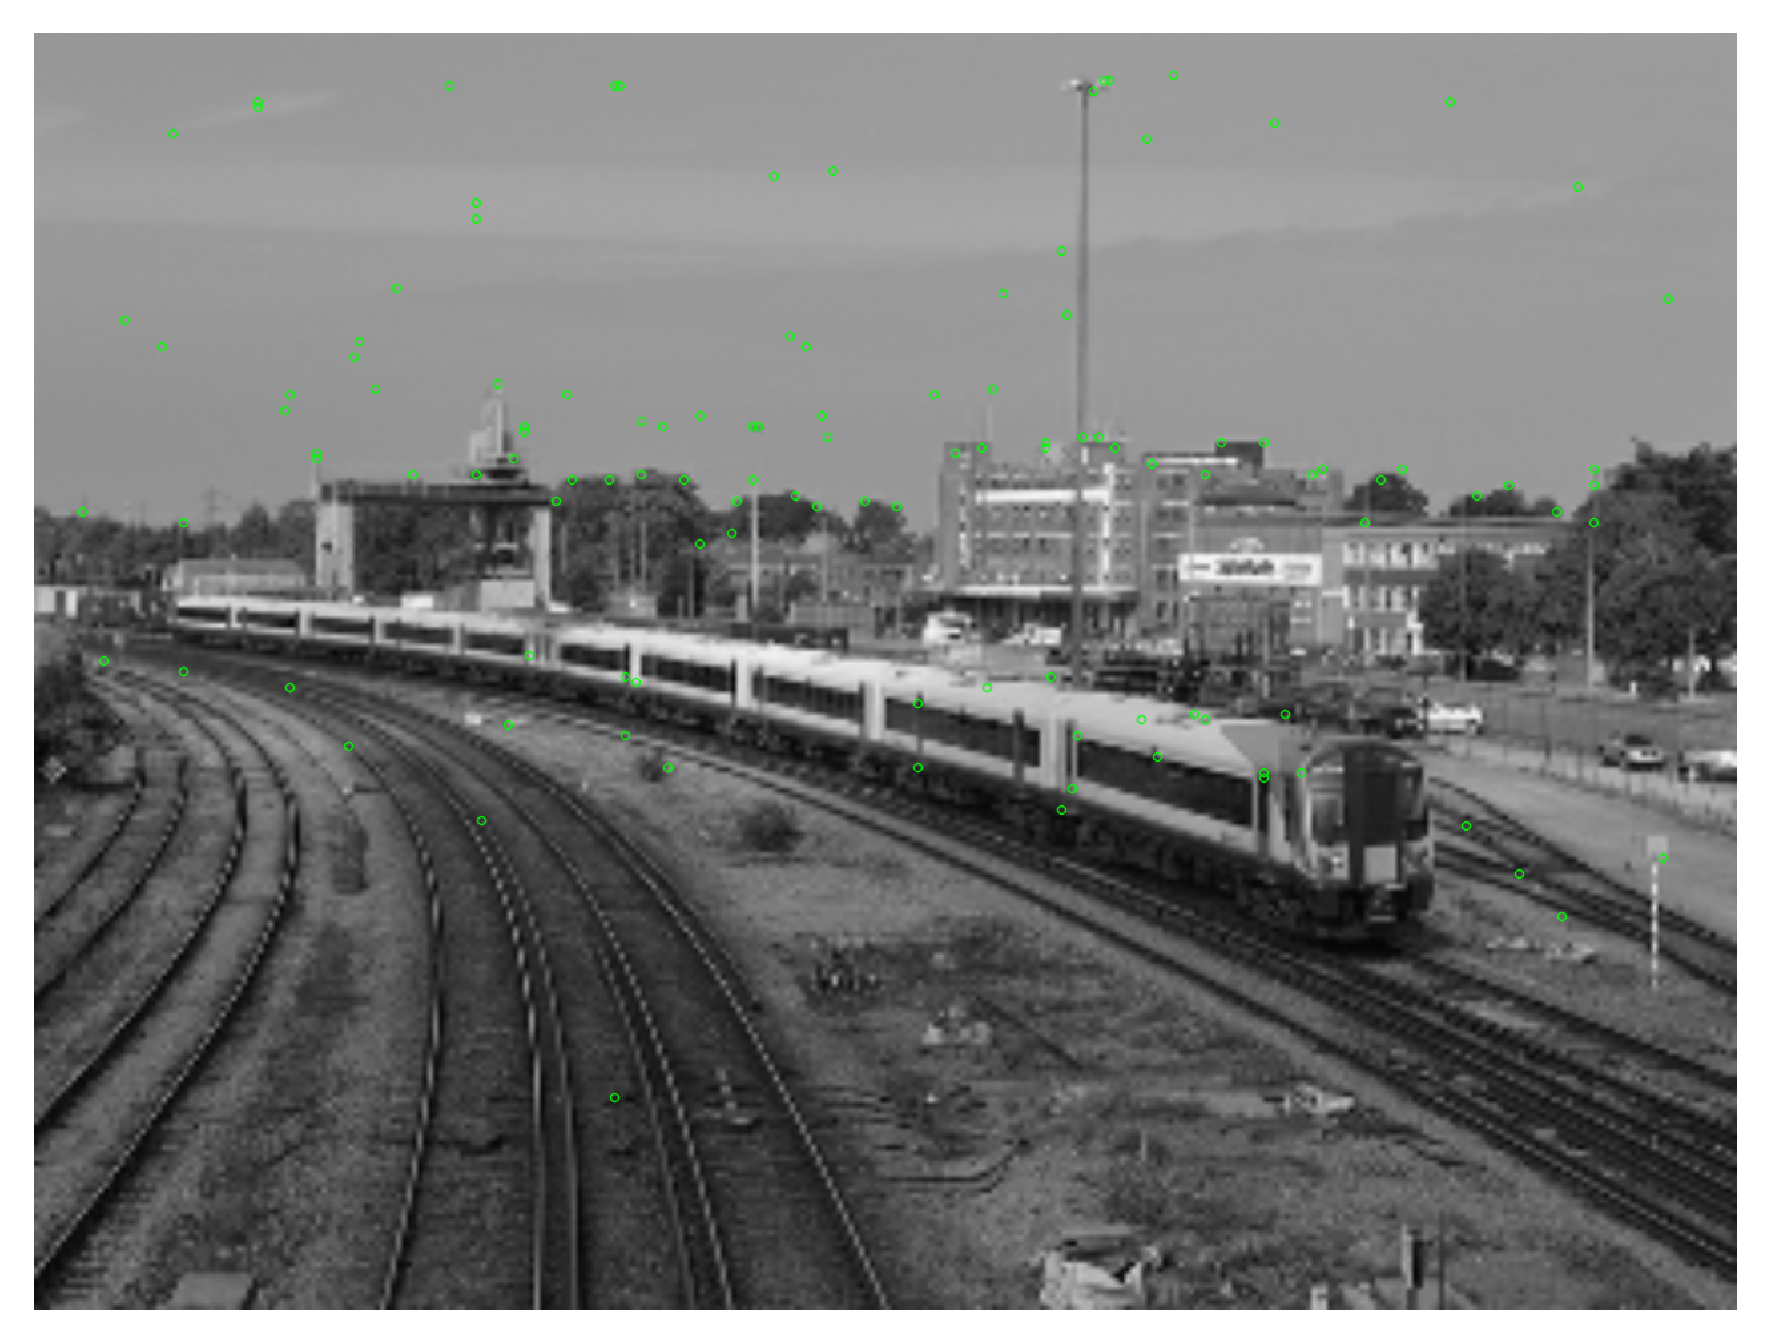

In [252]:
plot_imgs([draw_keypoints(im[..., 0], np.where(_out['H_probs'][0]>0.2), (0, 255, 0))/255.], dpi=300)

## Distribution of the homographies

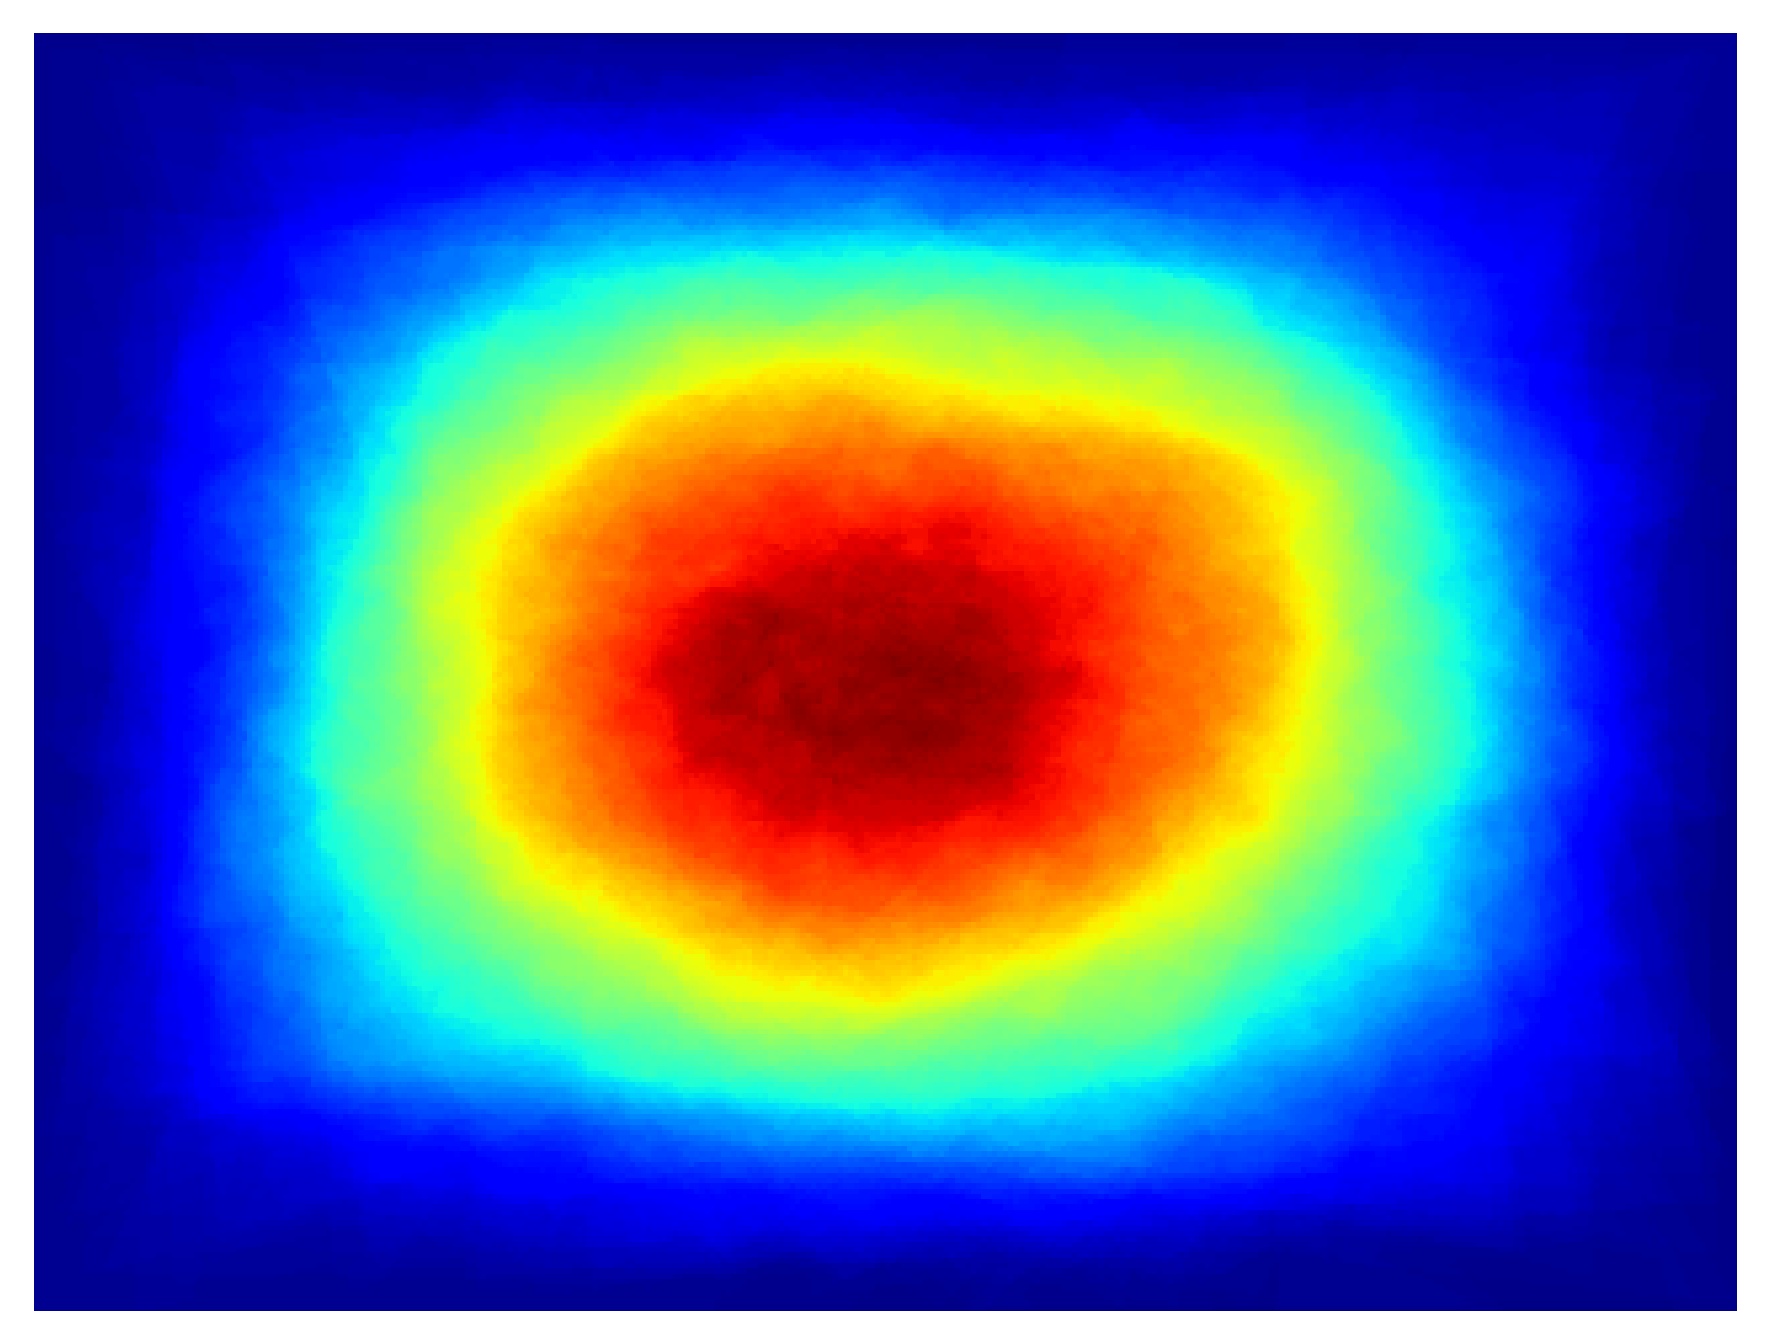

In [191]:
plot_imgs([_out['counts']/np.max(_out['counts'])], cmap='jet', dpi=300)